In [6]:
from google.colab import drive

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
cd /gdrive/MyDrive/GRADUATION/AUG/

/gdrive/MyDrive/GRADUATION/AUG


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
import condacolab
condacolab.install()

In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!python rapidsai-csp-utils/colab/install_rapids.py stable

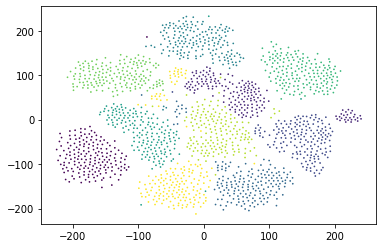

In [9]:
from sklearn.datasets import load_digits
X, y = load_digits().data, load_digits().target
from cuml.manifold import TSNE
tsne = TSNE(n_components = 2)
X_hat = tsne.fit_transform(X)

# To plot the embedding
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_hat[:,0], X_hat[:,1], c = y, s = 0.5)

In [10]:
from keras.models import model_from_json

def loadModel(dataname, name, num):

    file = open(f"../cBiGAN/{dataname}/Models/{name}.json", 'r')
    json = file.read()
    file.close()

    mod = model_from_json(json)
    mod.load_weights(f"../cBiGAN/{dataname}/Models/{name}_{num}.h5")

    return mod

E = loadModel('MNIST_digit', "enc", 100500)
G = loadModel('MNIST_digit', "gen", 100500)

In [11]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np

danger_df = pd.read_csv('../CV/MNIST_digit_danger_resnet50.csv')

from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.expand_dims(X_train, axis=-1)
X_train = X_train.astype(np.float32) / 255.0

X_test = np.expand_dims(X_test, axis=-1)
X_test = X_test.astype(np.float32) / 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [16]:
latent_original = E.predict([X_train, y_train])
latent_test = E.predict([X_test, y_test])

danger_df = pd.read_csv('../CV/MNIST_digit_danger_resnet50.csv')
# latent_original = np.load('../AUG/latent_MNIST_digit_train.npy')
indices = np.load('../AUG/knn_indices.npy')

danger_idx = danger_df['danger_idx'].to_numpy()
indices_d = indices[danger_idx]

In [56]:
from sklearn.model_selection import train_test_split

def make_SLATE(aug_total=20000, params=(0.25, 0.25, 0.25, 0.25)):

    AUG_TOTAL = aug_total

    a,b,c,d = [x*AUG_TOTAL for x in params]

    latents_SLATE = []
    latents_SLATE_flag = []

    generated_sets = []
    label_sets = []
    generated_flag = []

    # Plane SLATE
    if d > 0:
        aug_n_per_class = int(d // 10)
        latent_smote = []
        labels = []
        for label in range(10):
            target_idx = np.where(y_train==label)[0]
            population = np.random.choice(target_idx, aug_n_per_class)

            for i in population:
                me = latent_original[i]
                you_idx = np.random.choice(indices[i][1:])
                you = latent_original[you_idx]
                distance = (you - me) * np.random.uniform(low=0.0, high=1.0)
                new = me + distance

                latent_smote.append(new)
                labels.append(label)
        
        latent_smote = np.array(latent_smote)
        labels = np.array(labels)

        gen_smote = G.predict([latent_smote, labels])

        latents_SLATE.append(latent_smote)
        latents_SLATE_flag.append(['PS']*len(latent_smote))

        generated_sets += [gen_smote]
        label_sets.append(labels)
        generated_flag.append(['PS']*len(labels))

    # borderline SLATE
    if b+c > 0:
        aug_n = int((b+c)//len(danger_df) + 1)

        latent_smote = []
        labels_right = []
        labels_false = []

        danger_idx = danger_df['danger_idx'].to_numpy()
        indices_d = indices[danger_idx]

        for danger_nn in indices_d:
            me = latent_original[danger_nn[0]]
            yous_idx = np.random.choice(danger_nn[1:], aug_n)

            for you in latent_original[yous_idx]:
                distance = (you - me) * np.random.uniform(low=0.0, high=1.0)
                latent_smote.append(me + distance)
                labels_right.append(y_train[danger_nn[0]])
                labels_false.append(danger_df[danger_df['danger_idx']==danger_nn[0]]['wrong_answers'].values[0])

        if b>0 and c>0:
            z_smote_1, z_smote_2, right_1, right_2, wrong_1, wrong_2 = train_test_split(latent_smote, labels_right, labels_false, test_size=int(c), train_size=int(b))

            z_smote_1 = np.array(z_smote_1)
            z_smote_2 = np.array(z_smote_2)
            right_1 = np.array(right_1)
            wrong_2 = np.array(wrong_2)

            # generate smote imgs
            gen_smote1 = G.predict([z_smote_1, right_1])
            gen_smote2 = G.predict([z_smote_2, wrong_2])
            # generated_sets += [gen_smote1, gen_smote2]
            # label_sets += [right_1, wrong_2]



            latents_SLATE.append(z_smote_1)
            latents_SLATE_flag.append(['BS1']*len(z_smote_1))

            latents_SLATE.append(z_smote_2)
            latents_SLATE_flag.append(['BS2']*len(z_smote_2))

            generated_sets += [gen_smote1]
            label_sets.append(right_1)
            generated_flag.append(['BS1']*len(right_1))

            generated_sets += [gen_smote2]
            label_sets.append(wrong_2)
            generated_flag.append(['BS2']*len(wrong_2))


        
        elif b:
            z_smote, _, right, _, _, _ = train_test_split(latent_smote, labels_right, labels_false, test_size=int(len(latent_smote)-b), train_size=int(b))
            gen_smote1 = G.predict([np.array(z_smote), np.array(right)])
            generated_sets += [gen_smote1]
            label_sets += [right]
        else:
            z_smote, _, _, _, wrong, _ = train_test_split(latent_smote, labels_right, labels_false, test_size=int(len(latent_smote)-c), train_size=int(c))
            gen_smote2 = G.predict([np.array(z_smote), np.array(wrong)])
            generated_sets += [gen_smote2]
            label_sets += [wrong]

    # random generation
    if a > 0:
        x_input = np.random.randn(64 * int(a))
        z_input = x_input.reshape(int(a), 64)
        labels = np.array(list(range(10))*int(a//10))

        gen_random = G.predict([z_input, labels])
        # generated_sets += [gen_random]
        # label_sets += [labels]

        
        latents_SLATE.append(z_input)
        latents_SLATE_flag.append(['R']*len(z_input))

        generated_sets += [gen_random]
        generated_flag.append(['R']*len(labels))
        label_sets.append(labels)

    # add X_test, X_train
    latents_SLATE.append(E.predict([X_test, y_test]))
    generated_sets += [X_test]
    latents_SLATE_flag.append(['Test']*len(y_test))
    label_sets.append(y_test)

    latents_SLATE.append(E.predict([X_train, y_train]))
    generated_sets += [X_train]
    latents_SLATE_flag.append(['Train']*len(y_train))
    label_sets.append(y_train)


    slate_X = np.concatenate(generated_sets) * 255
    slate_y = np.concatenate(label_sets)

    return np.concatenate(latents_SLATE, axis=0), np.concatenate(latents_SLATE_flag), slate_X, slate_y,  np.concatenate(generated_flag)

In [57]:
latents_SLATE, latents_SLATE_flag, generated_sets, label_sets, generated_flag = make_SLATE()

In [58]:
latents_SLATE.shape, latents_SLATE_flag.shape, generated_sets.shape, label_sets.shape, generated_flag.shape

((90000, 64), (90000,), (90000, 28, 28, 1), (90000,), (20000,))

In [59]:
from sklearn.preprocessing import LabelEncoder

flag_le = LabelEncoder()
SLATE_flag = flag_le.fit_transform(latents_SLATE_flag)
flag_le.classes_

array(['BS1', 'BS2', 'PS', 'R', 'Test', 'Train'], dtype='<U5')

[W] [06:33:15.172757] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


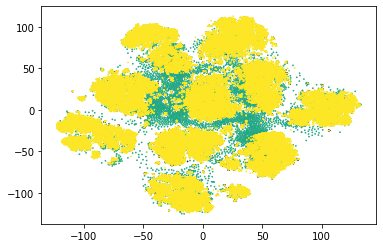

In [60]:
# Latent space tsne

tsne = TSNE(n_components = 2)
X_hat = tsne.fit_transform(latents_SLATE, )

# To plot the embedding
%matplotlib inline
plt.scatter(X_hat[:,0], X_hat[:,1], c = SLATE_flag, s = 0.5)

(-137.52780456542968, 124.6378662109375)
(-135.4417194366455, 145.74646034240723)


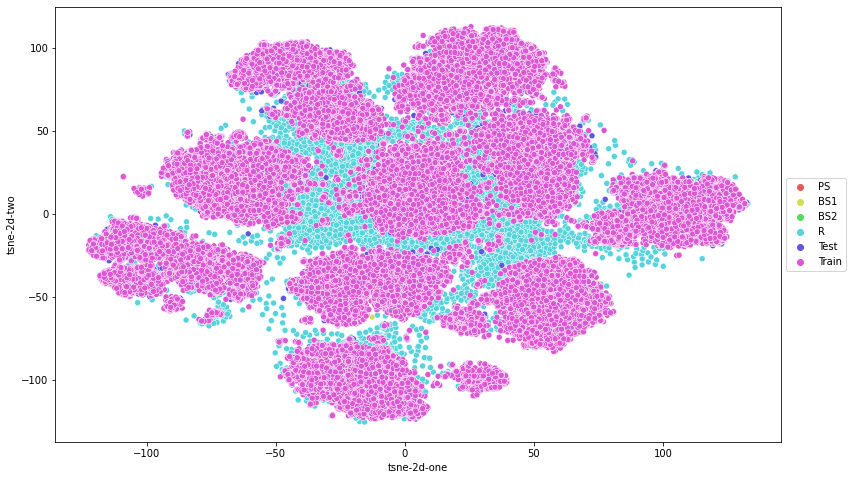

In [61]:
from pandas import DataFrame as df
import seaborn as sns

df_subset = df()

df_subset['tsne-2d-one'] = X_hat[:,0]
df_subset['tsne-2d-two'] = X_hat[:,1]
df_subset['label'] = latents_SLATE_flag


CAT_NUM = 6

plt.figure(figsize=(13,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", CAT_NUM),
    data=df_subset,
    legend="full",
    alpha=1,
)
# plt.title('전체 클래스 t-sne', fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-60, 75)
print(plt.gca().get_ylim())
ylim_ = plt.gca().get_ylim()
print(plt.gca().get_xlim())
xlim_ = plt.gca().get_xlim()
# plt.axis('off')
plt.show()

In [ ]:
latent_figs =[plt.scatter(x=X_hat[:,0][:5000], y=X_hat[:,1][:5000], c='#3367AB', s=2, alpha=1)  # PS
plt.scatter(x=X_hat[:,0][5000:10000], y=X_hat[:,1][5000:10000], c='#08C409', s=2, alpha=1)  # BS1
plt.scatter(x=X_hat[:,0][10000:15000], y=X_hat[:,1][10000:15000], c='#FF8900', s=2, alpha=1)  # BS2
plt.scatter(x=X_hat[:,0][15000:20000], y=X_hat[:,1][15000:20000], c='#F44D85', s=2, alpha=1)  # R
plt.scatter(x=X_hat[:,0][20000:30000], y=X_hat[:,1][20000:30000], c='#0F0F0F', s=2, alpha=0.4)  # X test
plt.scatter(x=X_hat[:,0][30000:40000], y=X_hat[:,1][30000:40000], c='#0F0F0F', s=1, alpha=0.1)]  # X train

fig, ax = plt.subplots()
lines = ax.plot(data)
ax.legend(custom_lines, ['Cold', 'Medium', 'Hot'])

In [91]:
X_train_latent_tsne = X_hat[30000:]
danger_latent_tsne = X_train_latent_tsne[danger_idx]
danger_latent_tsne.shape

(676, 2)

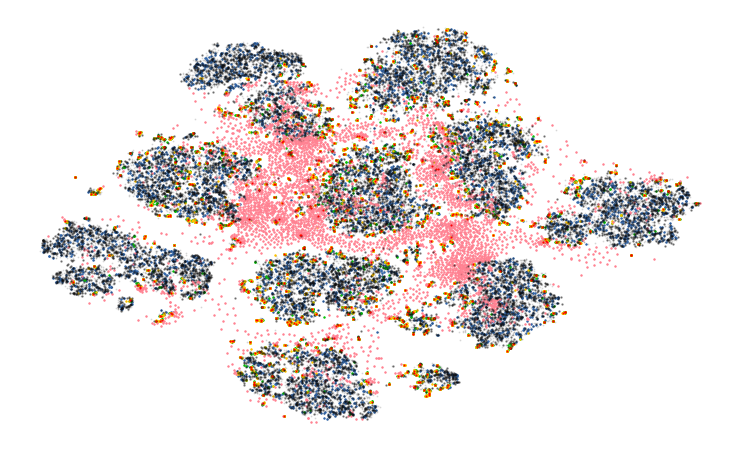

In [92]:
plt.figure(figsize=(13,8))
plt.scatter(x=X_hat[:,0][:5000], y=X_hat[:,1][:5000], c='#3367AB', s=2, alpha=1)  # PS
plt.scatter(x=X_hat[:,0][5000:10000], y=X_hat[:,1][5000:10000], c='#08C409', s=2, alpha=1)  # BS1
plt.scatter(x=X_hat[:,0][10000:15000], y=X_hat[:,1][10000:15000], c='#FFC300', s=2, alpha=1)  # BS2
plt.scatter(x=X_hat[:,0][15000:20000], y=X_hat[:,1][15000:20000], c='#FF8292', s=2, alpha=1)  # R
plt.scatter(x=X_hat[:,0][20000:30000], y=X_hat[:,1][20000:30000], c='#0F0F0F', s=2, alpha=0.4)  # X test
plt.scatter(x=X_hat[:,0][30000:50000], y=X_hat[:,1][30000:50000], c='#0F0F0F', s=1, alpha=0.1)  # X train
plt.scatter(x=danger_latent_tsne[:,0], y=danger_latent_tsne[:,1], c='#FF0000', s=1, alpha=1)  # DANGER
plt.axis('off')
plt.savefig('latent_tsne.png', dpi=300)

[W] [06:50:46.863719] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


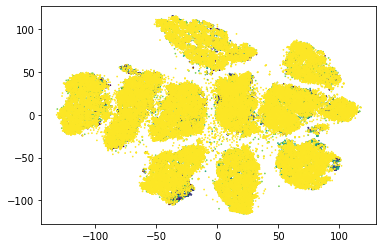

In [85]:
# data space tsne

tsne = TSNE(n_components = 2)
X_hat_ = tsne.fit_transform(generated_sets.reshape(generated_sets.shape[0], -1))

# To plot the embedding
%matplotlib inline
plt.scatter(X_hat_[:,0], X_hat_[:,1], c = SLATE_flag, s = 0.5)

In [94]:
X_train_data_tsne = X_hat_[30000:]
danger_data_tsne = X_train_latent_tsne[danger_idx]
danger_data_tsne.shape

(676, 2)

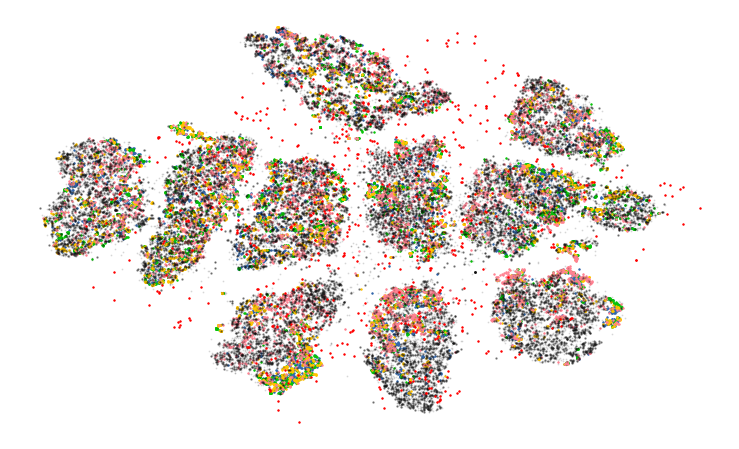

In [95]:
plt.figure(figsize=(13,8))
plt.scatter(x=X_hat_[:,0][:5000], y=X_hat_[:,1][:5000], c='#3367AB', s=2, alpha=1)  # PS
plt.scatter(x=X_hat_[:,0][5000:10000], y=X_hat_[:,1][5000:10000], c='#08C409', s=2, alpha=1)  # BS1
plt.scatter(x=X_hat_[:,0][10000:15000], y=X_hat_[:,1][10000:15000], c='#FFC300', s=2, alpha=1)  # BS2
plt.scatter(x=X_hat_[:,0][15000:20000], y=X_hat_[:,1][15000:20000], c='#FF8292', s=2, alpha=1)  # R
plt.scatter(x=X_hat_[:,0][20000:30000], y=X_hat_[:,1][20000:30000], c='#0F0F0F', s=2, alpha=0.4)  # X test
plt.scatter(x=X_hat_[:,0][30000:50000], y=X_hat_[:,1][30000:50000], c='#0F0F0F', s=1, alpha=0.1)  # X train
plt.scatter(x=danger_data_tsne[:,0], y=danger_data_tsne[:,1], c='#FF0000', s=2, alpha=1)  # DANGER
plt.axis('off')
plt.savefig('data_tsne.png', dpi=300)

(0.0, 28.0, 28.0, 0.0)

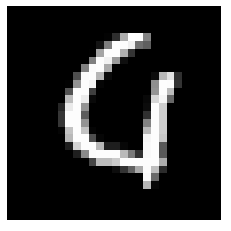

In [ ]:
from matplotlib import pyplot as plt

train_idx = danger_df.loc[71, 'danger_idx']

plt.imshow(X_train[train_idx].reshape(28,28)*255, cmap='gray')
plt.ylim((28,0))
plt.xlim((0,28))
plt.axis('off')

In [ ]:
train_idx

32108

In [ ]:
indices = np.load('knn_indices.npy')

In [ ]:
indices[train_idx]

array([32108, 38407, 32513, 14740, 14546, 56648, 46324, 50154, 10284,
       14720])

In [ ]:
tmp = []
for i in range(10):

    wrong_answers = danger_df[danger_df['right_answers']==i]['wrong_answers'].value_counts().to_frame().T
    wrong_answers.index = [i]
    
    tmp.append(wrong_answers)

wrong_answers_df = pd.concat(tmp, axis=0).fillna(0)
# wrong_answers_df

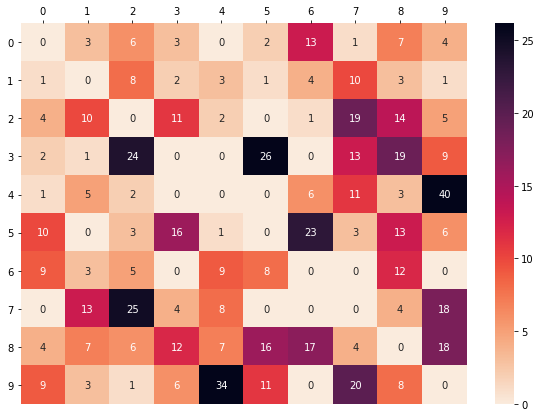

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
ax = sns.heatmap(wrong_answers_df, annot=True, robust=True, cmap=sns.cm.rocket_r)
plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.show()

In [ ]:
i = 0
danger_df[danger_df['right_answers']==i]['danger_idx']

danger_idx  wrong_answers  right_answers
0            80              8            9.0
1           318              7            2.0
2           494              0            6.0
3           635              2            5.0
4           995              4            7.0
..          ...            ...            ...
671       57302              6            5.0
672       57662              6            5.0
673       58258              4            7.0
674       58539              7            9.0
675       58926              6            1.0

[676 rows x 3 columns]

In [ ]:
# encode all
# latent_original = E.predict([X_train, y_train])
# np.save('latent_MNIST_digit_train.npy', latent_original)
latent_original = np.load('latent_MNIST_digit_train.npy')

(-0.5, 27.5, 27.5, -0.5)

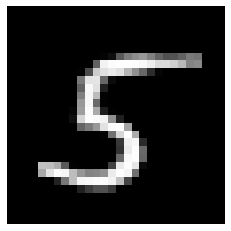

In [ ]:
zero_fake = G.predict([np.array([np.zeros(64)]), np.array([5])])
zero_fake = zero_fake[0].reshape(28,28) * 255
plt.imshow(zero_fake, cmap='gray')
plt.axis('off')

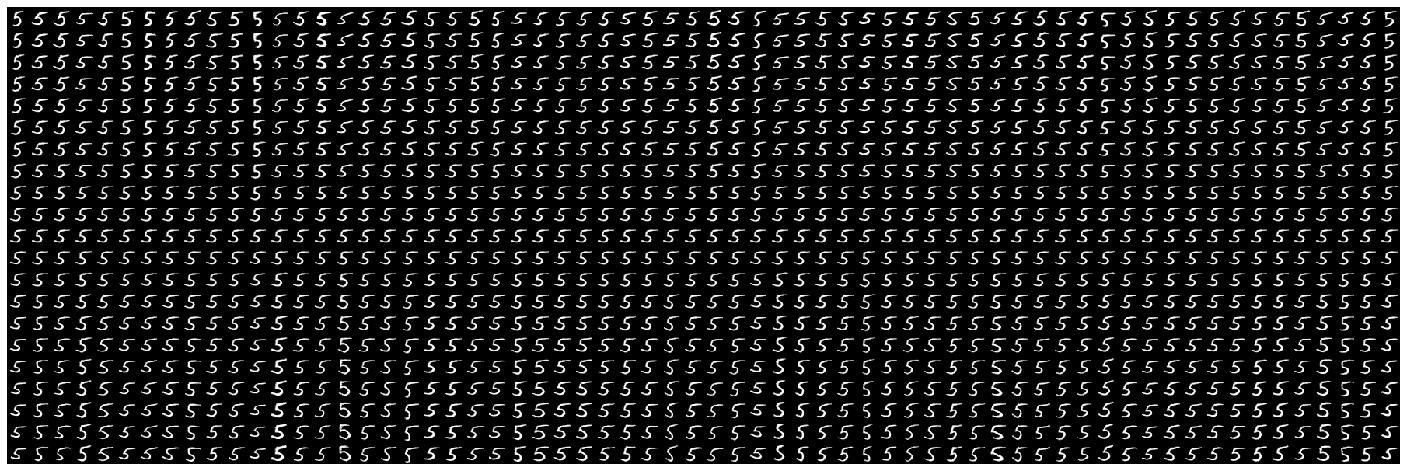

In [ ]:
def latent_check(z=np.zeros(64), c=7):
    zero_fake = G.predict([np.array([z]), np.array([c])])
    zero_fake = zero_fake[0].reshape(28,28) * 255
    return zero_fake

def steer_z(dim):
    zs = []
    for x in np.arange(-3,3.3,0.3):
        zeros = np.zeros(64)
        zeros[dim] = x
        zs.append(zeros)
    return np.array(zs)


from tqdm.auto import tqdm

interpols = []
for dim in tqdm(range(0,64)):
    interpol_dim = np.concatenate([latent_check(z,5) for z in steer_z(dim)], axis=0)
    interpols.append(interpol_dim)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(np.concatenate(interpols, axis=1), interpolation='nearest', cmap='gray')
plt.tight_layout()
plt.axis('off')
plt.show()

In [ ]:
for i in range(64):
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

In [ ]:
z = np.random.randn(64)


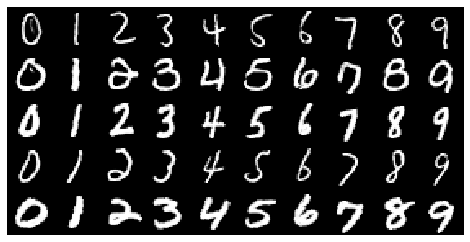

In [ ]:
cols = []
for _ in range(5):
    z = np.random.randn(64)
    z = np.array(list(z)*10)
    z = z.reshape(-1, 64)
    labels = np.arange(0,10)
    line = G.predict([z, labels])
    line = line.reshape(10, 28, 28)
    line = np.concatenate(line, axis=-1)
    cols.append(line)
fig, ax = plt.subplots(figsize=(7, 4))
ax.imshow(np.concatenate(cols, axis=0), interpolation='nearest', cmap='gray')
plt.tight_layout()
plt.axis('off')
plt.show()

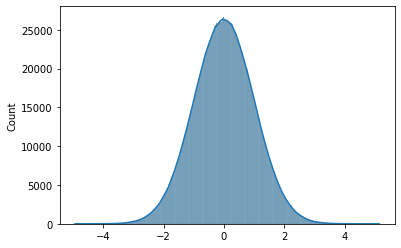

In [ ]:
sns.histplot(np.random.randn(60000*64), kde=True)

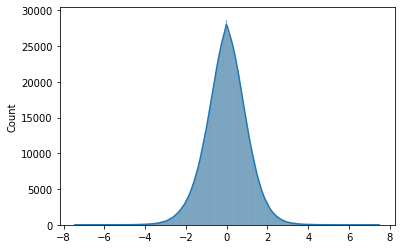

In [ ]:
sns.histplot(latent_original.flatten(), kde=True)

In [ ]:
# custom borderline-SMOTE

from sklearn.neighbors import NearestNeighbors
import numpy as np

# nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(latent_original)
# distances, indices = nbrs.kneighbors(latent_original)

In [ ]:
# np.save('knn_indices.npy', indices)

In [ ]:
indices = np.load('knn_indices.npy')

In [ ]:
len(danger_df)

676

In [ ]:
from tqdm.auto import tqdm

aug_n = 10

latent_smote = []
labels_right = []
labels_false = []

danger_idx = danger_df['danger_idx'].to_numpy()
indices_d = indices[danger_idx]

for danger_nn in tqdm(indices_d):
    me = latent_original[danger_nn[0]]
    yous_idx = np.random.choice(danger_nn[1:], aug_n)

    for you in latent_original[yous_idx]:
        distance = (you - me) * np.random.uniform()
        latent_smote.append(me + distance)
        #latent_smote_near.append(me + distance*.5)
        labels_right.append(y_train[danger_nn[0]])
        labels_false.append(danger_df[danger_df['danger_idx']==danger_nn[0]]['wrong_answers'].values[0])

In [ ]:
latent_smote = np.array(latent_smote)
labels_right = np.array(labels_right)
labels_false = np.array(labels_false)

In [ ]:
# tsne

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
import numpy as np

In [ ]:
# for random
z = np.random.randn(64*5000)
z = z.reshape(-1, 64)
labels_random = np.random.choice(range(10), 5000)

In [ ]:
# images

# origianl
X_origin = X_train[:10000].reshape(X_train[:10000].shape[0], 28, 28)
X_origin = X_origin.reshape(X_origin.shape[0], -1)

# danger
danger_img = X_train[danger_idx].reshape(X_train[danger_idx].shape[0], 28, 28)
danger_img = danger_img.reshape(danger_img.shape[0], -1)

# smote 1&2
s1_img = G.predict([latent_smote, labels_right])
s1_img = s1_img.reshape(s1_img.shape[0], -1)
s2_img = G.predict([latent_smote, labels_false])
s2_img = s2_img.reshape(s2_img.shape[0], -1)

# random
rand_img = G.predict([z, labels_random])
rand_img = rand_img.reshape(rand_img.shape[0], -1)

In [ ]:
X = np.concatenate([X_origin, danger_img, s1_img, s2_img, rand_img])
X.shape

(29196, 784)

In [ ]:
# labels
# o:original / d:danger / s1:smote1 / s2:smote2 / r:random

# labels original
label_origin = y_train[:10000]
label_origin = [f'{x}_o' for x in label_origin]

# danger labels
danger_labels = [f'{int(x)}_d' for x in list(danger_df['right_answers'])]

# smote labels
labels_right_ = [f'{x}_s1' for x in labels_right]
labels_false_ = [f'{x}_s2' for x in labels_false]

# random labels
labels_random_ = [f'{x}_r' for x in labels_random]

labels = np.concatenate([label_origin, danger_labels, labels_right_, labels_false_, labels_random_])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(labels)

print(le.classes_)

['0_d' '0_o' '0_r' '0_s1' '0_s2' '1_d' '1_o' '1_r' '1_s1' '1_s2' '2_d'
 '2_o' '2_r' '2_s1' '2_s2' '3_d' '3_o' '3_r' '3_s1' '3_s2' '4_d' '4_o'
 '4_r' '4_s1' '4_s2' '5_d' '5_o' '5_r' '5_s1' '5_s2' '6_d' '6_o' '6_r'
 '6_s1' '6_s2' '7_d' '7_o' '7_r' '7_s1' '7_s2' '8_d' '8_o' '8_r' '8_s1'
 '8_s2' '9_d' '9_o' '9_r' '9_s1' '9_s2']


In [ ]:
# latent

# original
latent_ori = latent_original[:10000]
# danger
latent_danger = latent_original[danger_idx]
# s1&s2
# latnet_s1 = E.predict([G.predict([latent_smote, labels_right]), labels_right])
# latnet_s2 = E.predict([G.predict([latent_smote, labels_false]), labels_false])
latent_s = latent_smote
# random
latent_random = E.predict([G.predict([z, labels_random]), labels_random])

latents = np.concatenate([latent_ori, latent_danger, latent_s, latent_random])

In [ ]:
# L

# labels
# o:original / d:danger / s1:smote1 / s2:smote2 / r:random

# labels original
label_origin = y_train[:10000]
label_origin = [f'{x}_o' for x in label_origin]

# danger labels
danger_labels = [f'{int(x)}_d' for x in list(danger_df['right_answers'])]

# smote labels
labels_right_ = [f'{x}_s1' for x in labels_right]

# random labels
labels_random_ = [f'{x}_r' for x in labels_random]

labels = np.concatenate([label_origin, danger_labels, labels_right_, labels_random_])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(labels)

print(le.classes_)

['0_d' '0_o' '0_r' '0_s1' '1_d' '1_o' '1_r' '1_s1' '2_d' '2_o' '2_r'
 '2_s1' '3_d' '3_o' '3_r' '3_s1' '4_d' '4_o' '4_r' '4_s1' '5_d' '5_o'
 '5_r' '5_s1' '6_d' '6_o' '6_r' '6_s1' '7_d' '7_o' '7_r' '7_s1' '8_d'
 '8_o' '8_r' '8_s1' '9_d' '9_o' '9_r' '9_s1']


In [ ]:
latents.shape

(22436, 64)

In [ ]:
len(set(df_subset['label']))

40

In [ ]:
# L
feat_cols = ['pixel'+str(i) for i in range(len(latents[0])) ]

df = pd.DataFrame(latents,columns=feat_cols)
df['y'] = y
df['label'] = labels

print( 'Size of the dataframe: {}'.format(df.shape) )

time_start = time.time()
df_subset = df.copy()
data_subset = df_subset[feat_cols].values
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=500)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Size of the dataframe: (22436, 66)
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 22436 samples in 0.172s...
[t-SNE] Computed neighbors for 22436 samples in 63.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22436
[t-SNE] Computed conditional probabilities for sample 2000 / 22436
[t-SNE] Computed conditional probabilities for sample 3000 / 22436
[t-SNE] Computed conditional probabilities for sample 4000 / 22436
[t-SNE] Computed conditional probabilities for sample 5000 / 22436
[t-SNE] Computed conditional probabilities for sample 6000 / 22436
[t-SNE] Computed conditional probabilities for sample 7000 / 22436
[t-SNE] Computed conditional probabilities for sample 8000 / 22436
[t-SNE] Computed conditional probabilities for sample 9000 / 22436
[t-SNE] Computed conditional probabilities for sample 10000 / 22436
[t-SNE] Computed conditional probabilities for sample 11000 / 22436
[t-SNE] Computed conditional probabilities for sample 12000 / 22436
[t-SNE] Comput

In [ ]:
latents.shape

(22436, 64)

In [ ]:
tsne_results.shape

(22436, 2)

(-44.00121574401855, 44.30029563903808)
(-41.731797981262204, 43.400159645080564)


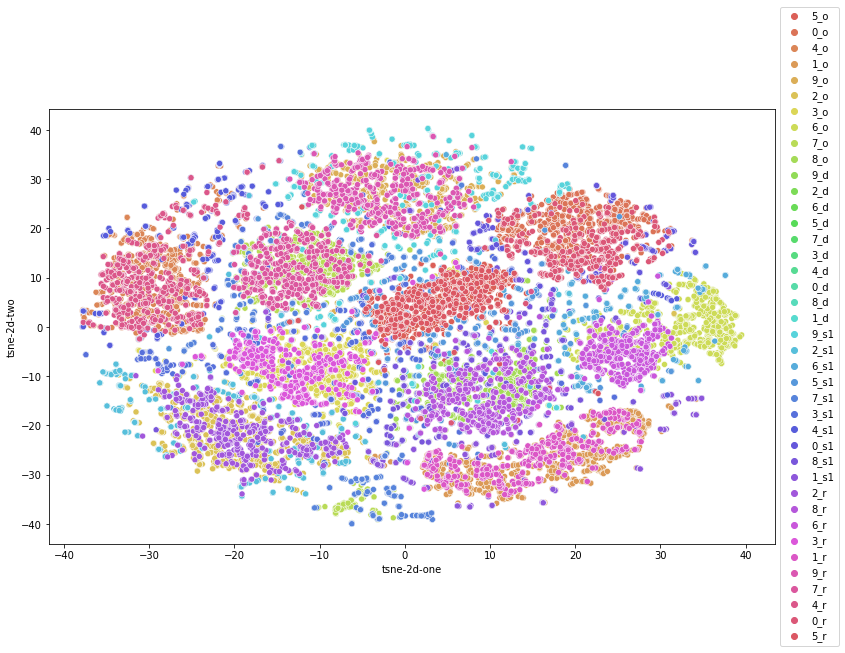

In [ ]:
# feat_cols = ['pixel'+str(i) for i in range(len(latents[0])) ]

# df = pd.DataFrame(latents,columns=feat_cols)
# df['y'] = y
# df['label'] = labels

# print( 'Size of the dataframe: {}'.format(df.shape) )

# time_start = time.time()
# df_subset = df.copy()
# data_subset = df_subset[feat_cols].values

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

CAT_NUM = len(set(df['label']))

plt.figure(figsize=(13,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", CAT_NUM),
    data=df_subset,
    legend="full",
    alpha=1,
)
# plt.title('전체 클래스 t-sne', fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-60, 75)
print(plt.gca().get_ylim())
ylim_ = plt.gca().get_ylim()
print(plt.gca().get_xlim())
xlim_ = plt.gca().get_xlim()
# plt.axis('off')
plt.show()

In [ ]:
df_subset['label'].unique()

array(['5_o', '0_o', '4_o', '1_o', '9_o', '2_o', '3_o', '6_o', '7_o',
       '8_o', '9_d', '2_d', '6_d', '5_d', '7_d', '3_d', '4_d', '0_d',
       '8_d', '1_d', '9_s1', '2_s1', '6_s1', '5_s1', '7_s1', '3_s1',
       '4_s1', '0_s1', '8_s1', '1_s1', '2_r', '8_r', '6_r', '3_r', '1_r',
       '9_r', '7_r', '4_r', '0_r', '5_r'], dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


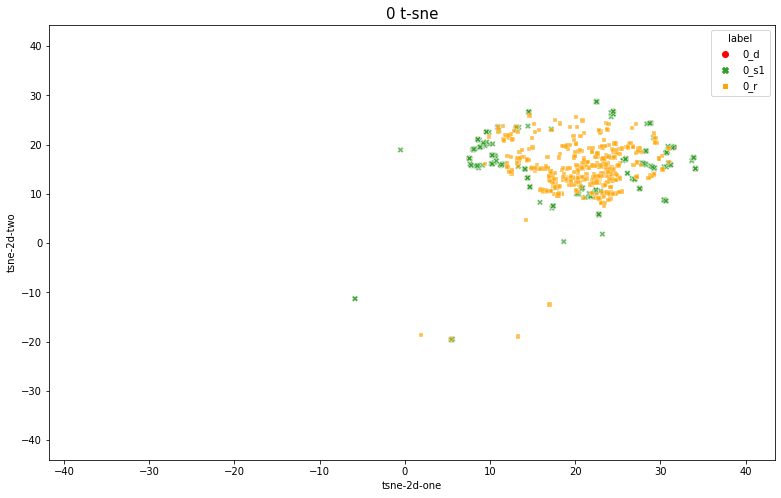

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


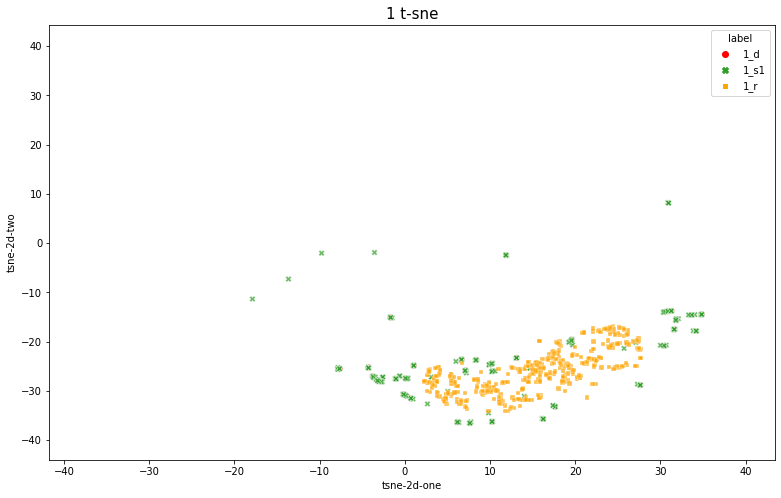

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


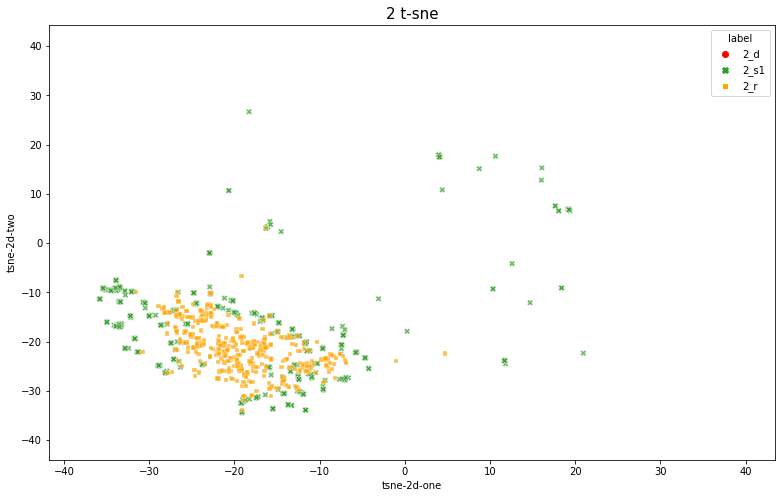

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


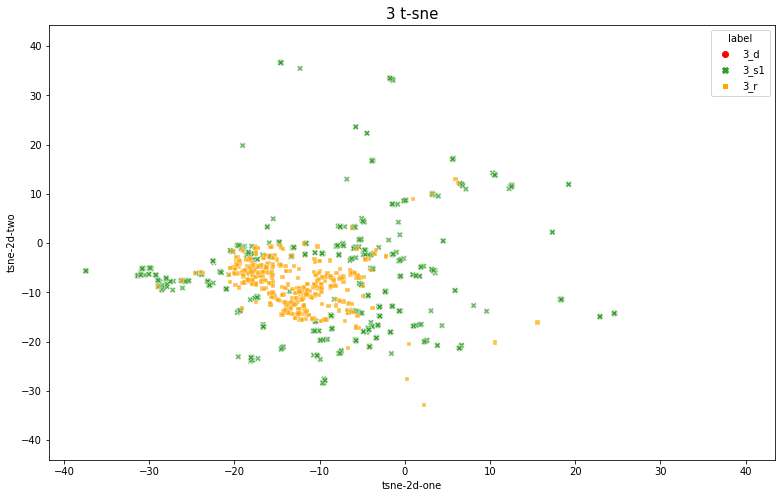

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


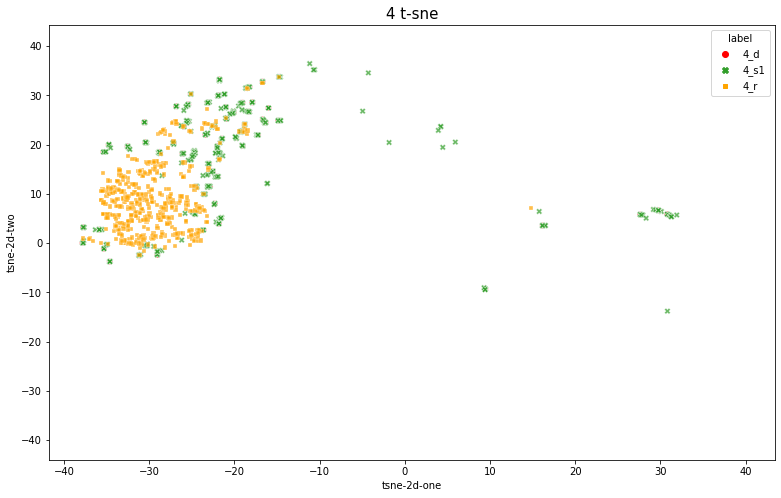

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


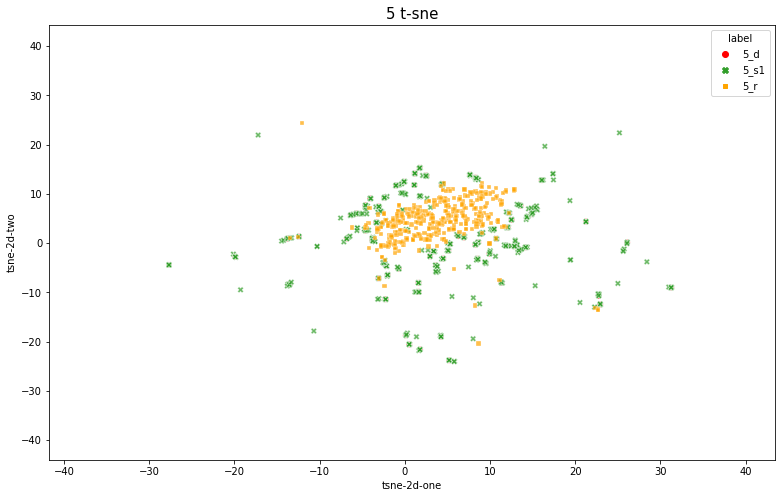

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


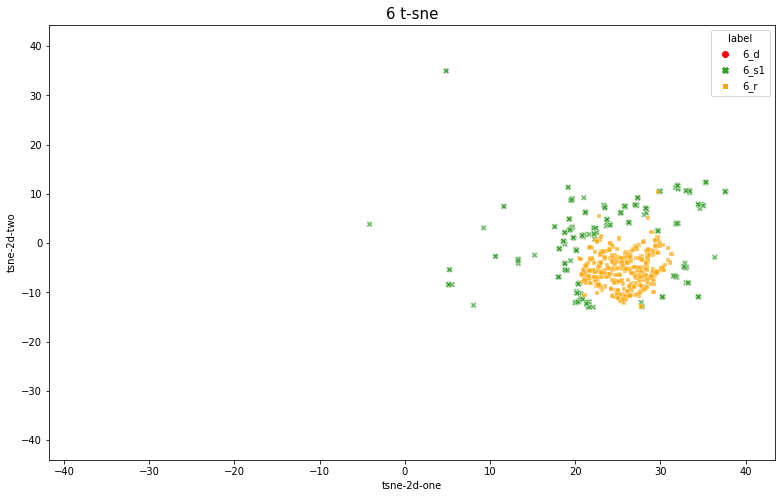

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


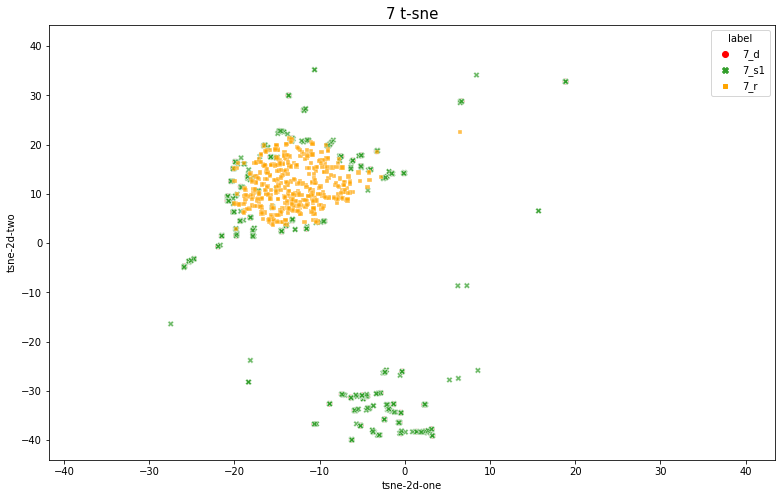

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


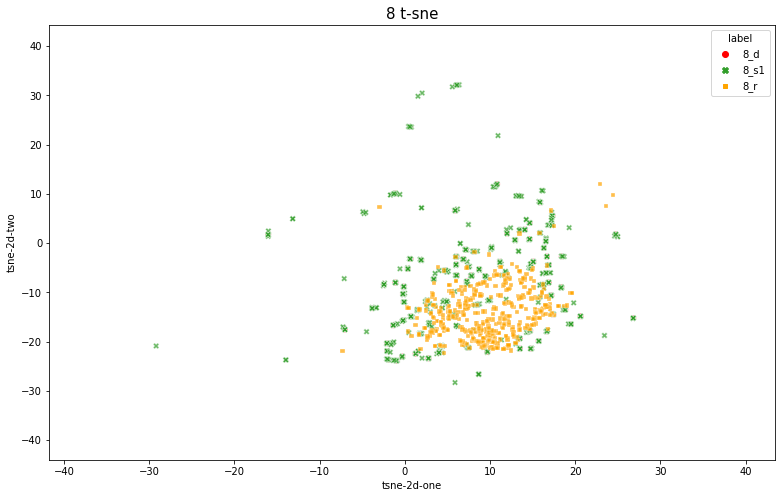

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


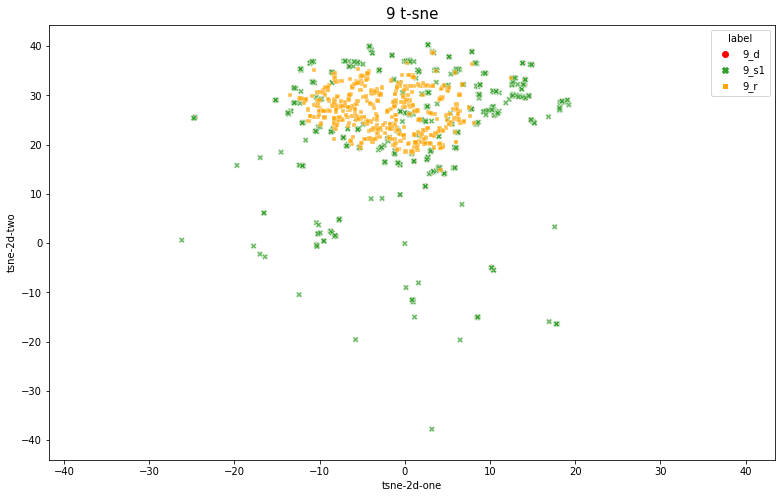

In [ ]:
cat_list = [str(x) for x in range(10)]
no_origin = list(filter(lambda x: not('o' in x), le.classes_))
def draw_tsne(category):
    df_subset_ = df_subset[df_subset['label'].isin(no_origin)]
    df_subset_ = df_subset_[df_subset['label'].str.split('_', n=1, expand=True)[0].isin([category])]
    
    plt.figure(figsize=(13,8))
    df_subset_['label'].unique()
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="label",
        # palette=sns.color_palette("hls", 2),
        data=df_subset_,
        legend="full",
        alpha=0.7,
        style='label',
        palette={a:b for a,b in zip(df_subset_['label'].unique(), ['red', '#2F9D27', 'orange', ])}  #  '#3DB7CC' '#D9418C',
    )
    
    plt.title(category+' t-sne', fontsize=15)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    plt.show()
for category in cat_list:
    draw_tsne(category)

In [ ]:
feat_cols = ['pixel'+str(i) for i in range(len(X[0])) ]

df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = labels

print( 'Size of the dataframe: {}'.format(df.shape) )

Size of the dataframe: (29196, 786)


In [ ]:
import matplotlib.pyplot as plt

# Plot the graph
# plt.gray()
# fig = plt.figure( figsize=(16,7) )
# for i in range(0,30):
#     ax  = fig.add_subplot(3,10,i+1)
#     ax.matshow(df.loc[i, feat_cols].values.reshape((28,28)).astype(float))
#     ax.axis('off')

# plt.show()

In [ ]:
time_start = time.time()
df_subset = df.copy()
data_subset = df_subset[feat_cols].values
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=500)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 29196 samples in 4.572s...
[t-SNE] Computed neighbors for 29196 samples in 1213.331s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29196
[t-SNE] Computed conditional probabilities for sample 2000 / 29196
[t-SNE] Computed conditional probabilities for sample 3000 / 29196
[t-SNE] Computed conditional probabilities for sample 4000 / 29196
[t-SNE] Computed conditional probabilities for sample 5000 / 29196
[t-SNE] Computed conditional probabilities for sample 6000 / 29196
[t-SNE] Computed conditional probabilities for sample 7000 / 29196
[t-SNE] Computed conditional probabilities for sample 8000 / 29196
[t-SNE] Computed conditional probabilities for sample 9000 / 29196
[t-SNE] Computed conditional probabilities for sample 10000 / 29196
[t-SNE] Computed conditional probabilities for sample 11000 / 29196
[t-SNE] Computed conditional probabilities for sample 12000 / 29196
[t-SNE] Computed conditional probabilities for 

In [ ]:
cat_list = [str(x) for x in range(10)]
def draw_tsne(category):
    # df_subset_ = df_subset[df_subset['label'].isin(no_origin)]
    df_subset_ = df_subset[df_subset['label'].str.split('_', n=1, expand=True)[0].isin([category])]
    
    plt.figure(figsize=(13,8))
    df_subset_['label'].unique()
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="label",
        # palette=sns.color_palette("hls", 2),
        data=df_subset_,
        legend="full",
        alpha=0.7,
        style='label',
        palette={a:b for a,b in zip(df_subset_['label'].unique(), ['#D9418C','red', '#2F9D27', 'orange', '#3DB7CC'])}  #  
    )
    
    plt.title(category+' t-sne', fontsize=15)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    plt.show()

(-39.21030120849609, 39.153385925292966)
(-38.1232234954834, 37.44750328063965)


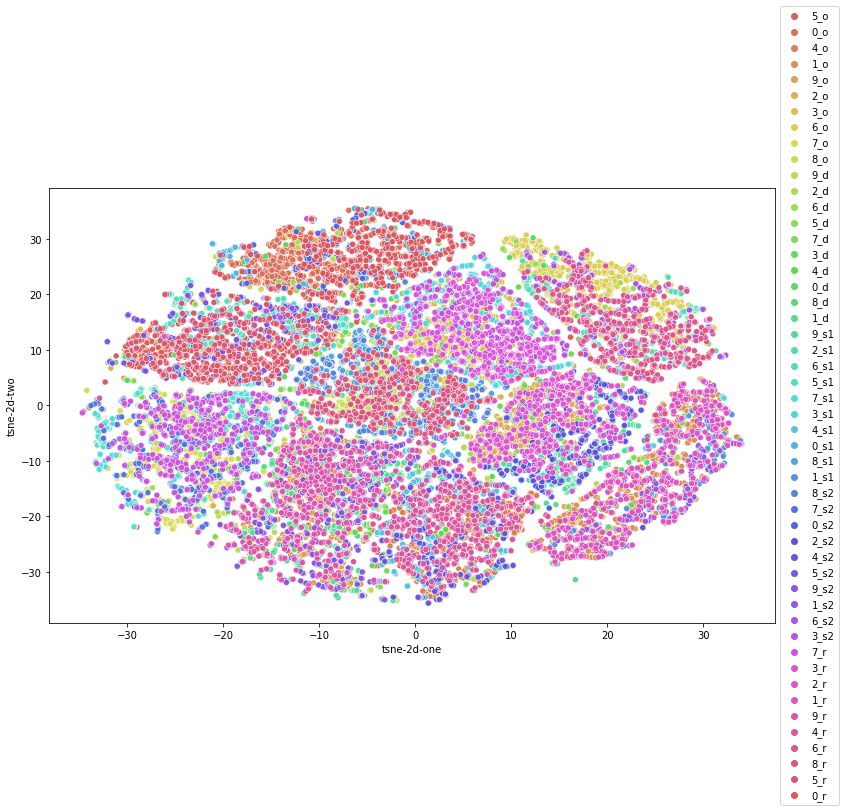

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

CAT_NUM = len(set(df['label']))

plt.figure(figsize=(13,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", CAT_NUM),
    data=df_subset,
    legend="full",
    alpha=1,
)
# plt.title('전체 클래스 t-sne', fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-60, 75)
print(plt.gca().get_ylim())
ylim_ = plt.gca().get_ylim()
print(plt.gca().get_xlim())
xlim_ = plt.gca().get_xlim()
# plt.axis('off')
plt.show()

In [ ]:
cat_list = [str(x) for x in range(10)]
cat_list

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
no_origin = list(filter(lambda x: not('o' in x), le.classes_))

In [ ]:
def draw_tsne(category):
    df_subset_ = df_subset[df_subset['label'].isin(no_origin)]
    df_subset_ = df_subset_[df_subset['label'].str.split('_', n=1, expand=True)[0].isin([category])]
    
    plt.figure(figsize=(13,8))
    df_subset_['label'].unique()
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="label",
        # palette=sns.color_palette("hls", 2),
        data=df_subset_,
        legend="full",
        alpha=0.7,
        style='label',
        palette={a:b for a,b in zip(df_subset_['label'].unique(), ['red', '#2F9D27', 'orange', '#3DB7CC'])}  # '#D9418C', 
    )
    
    plt.title(category+' t-sne', fontsize=15)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


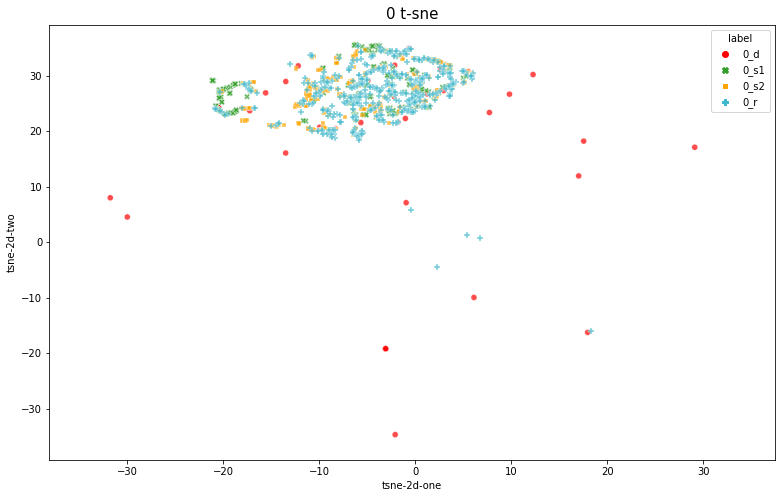

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


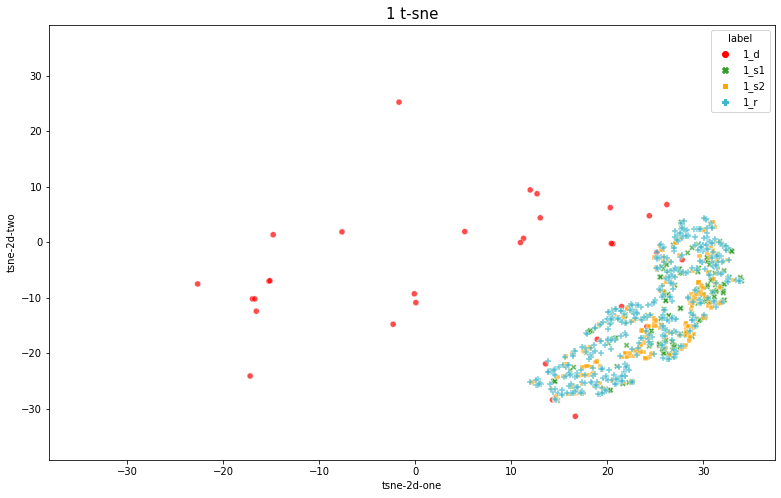

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


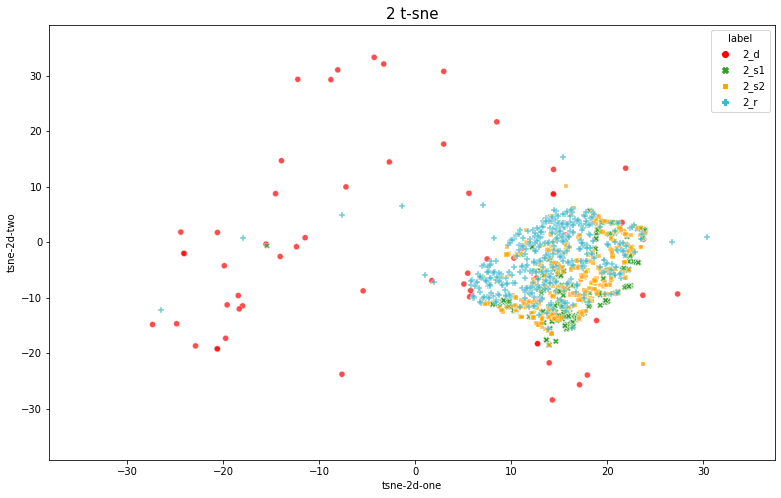

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


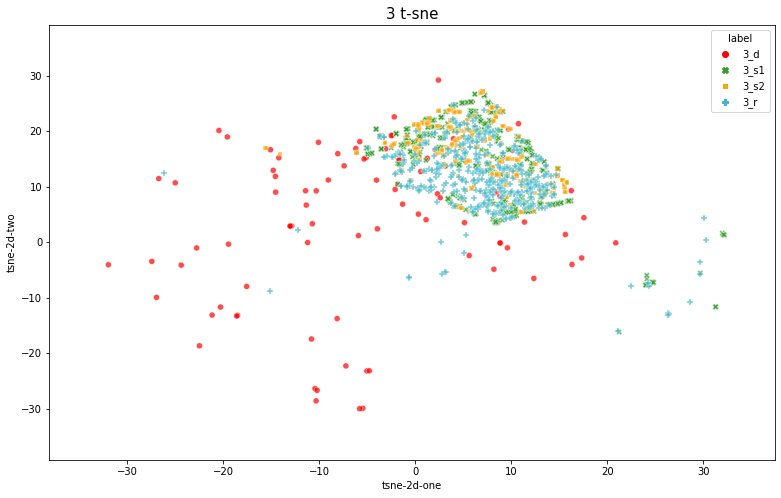

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


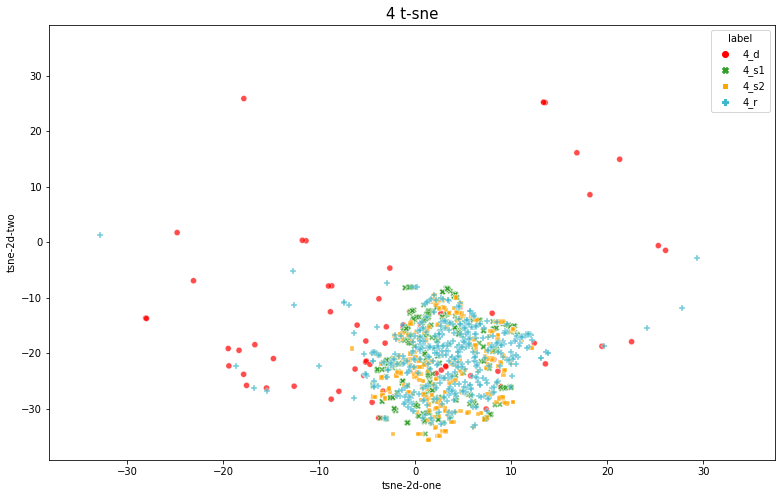

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


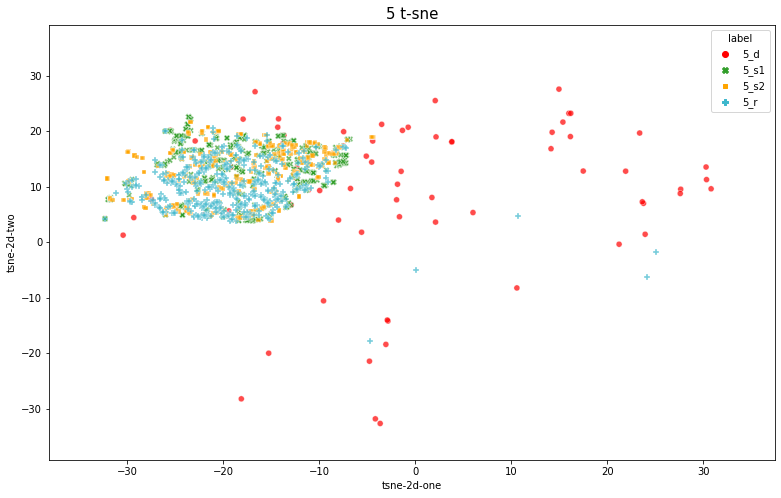

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


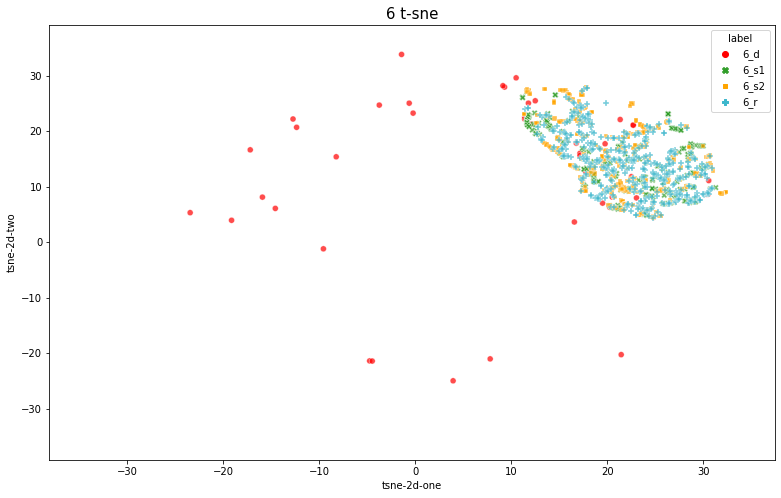

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


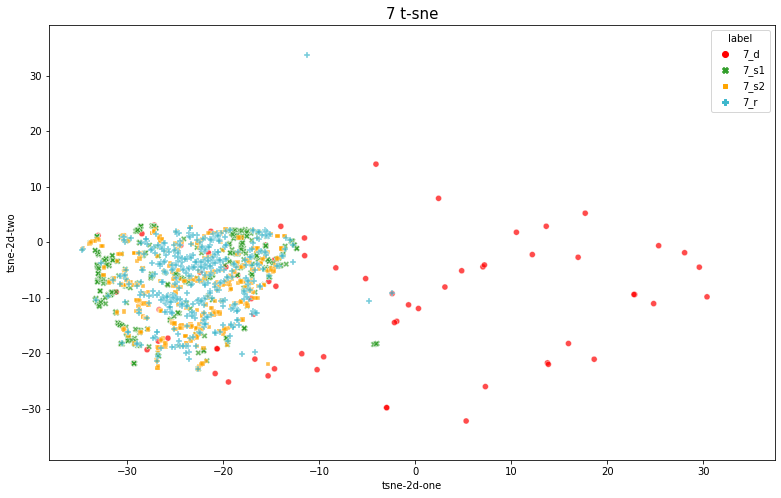

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


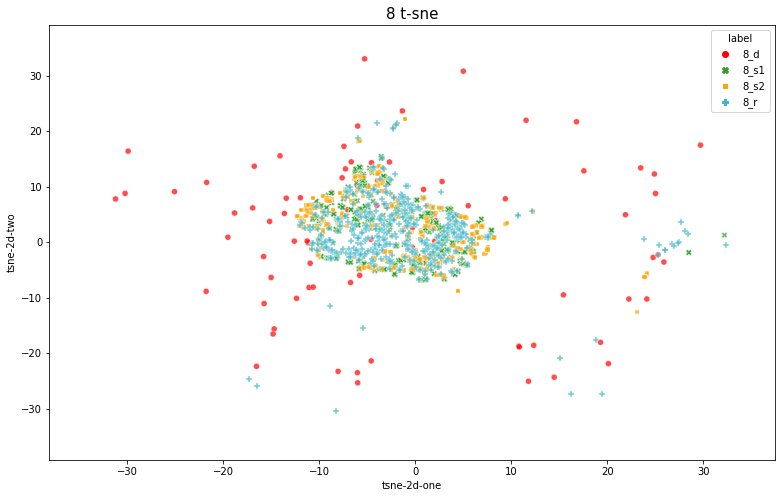

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


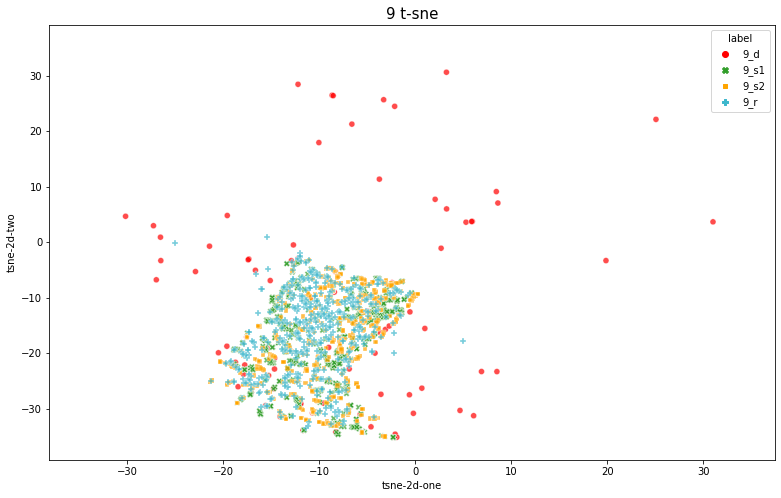

In [ ]:
for category in cat_list:
    draw_tsne(category)

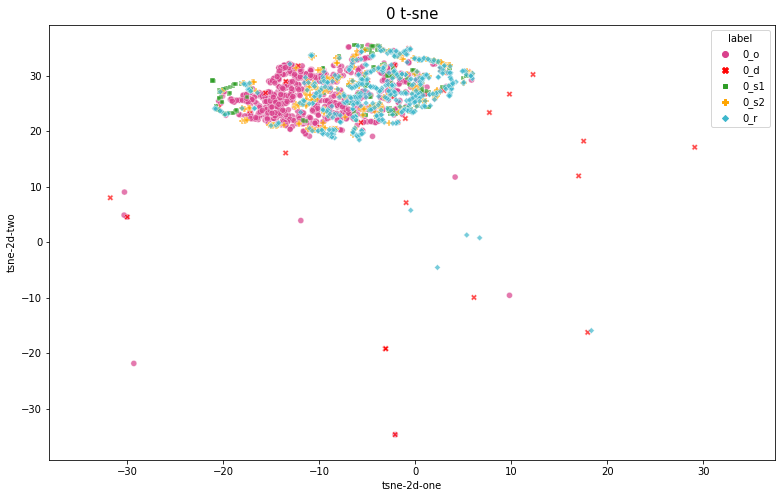

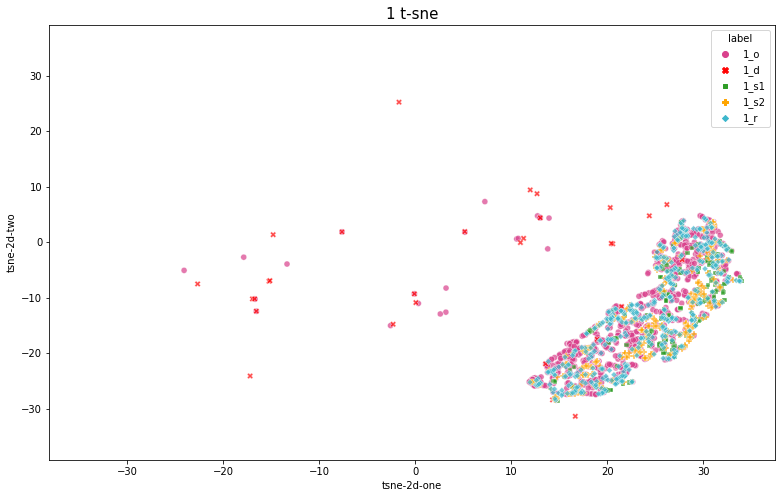

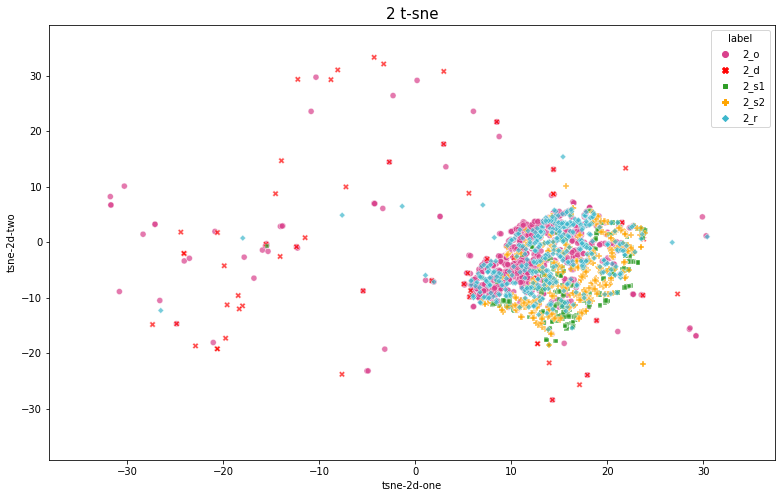

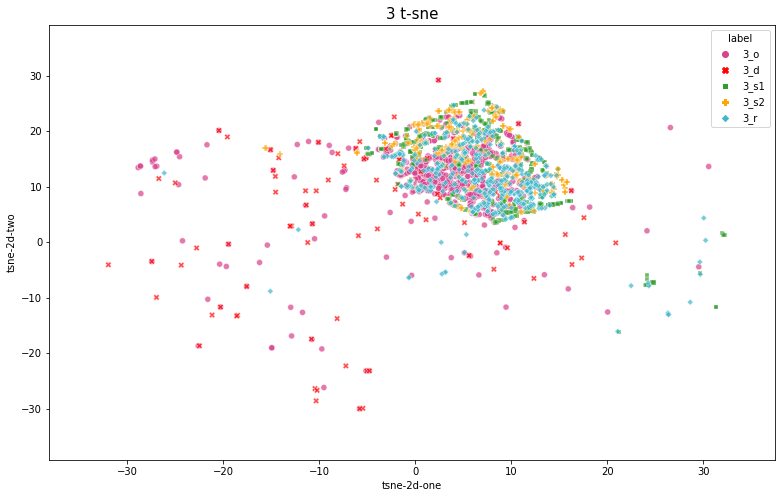

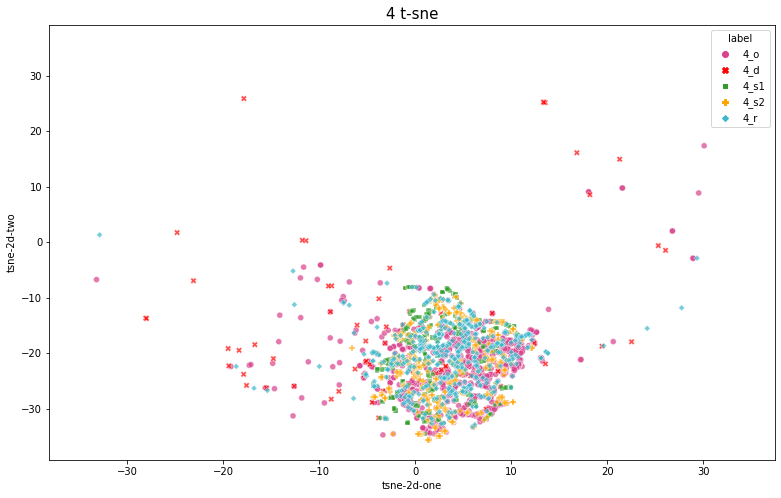

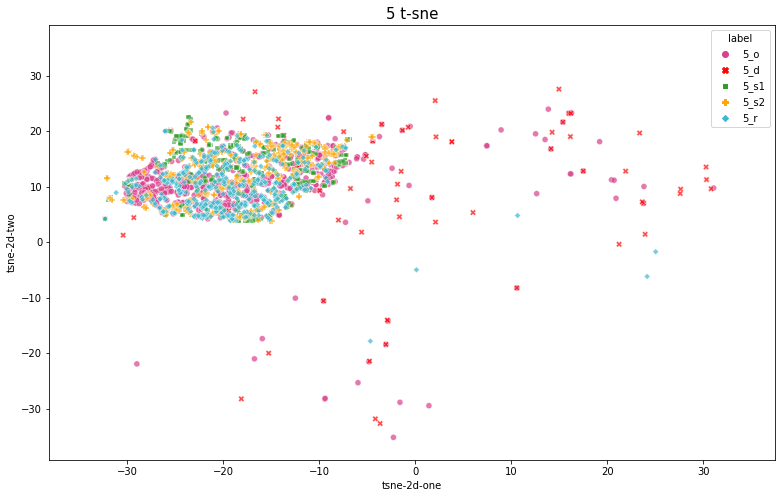

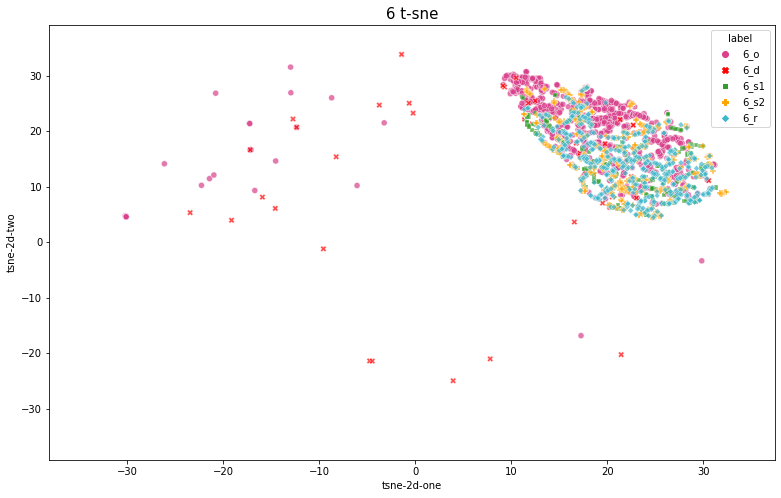

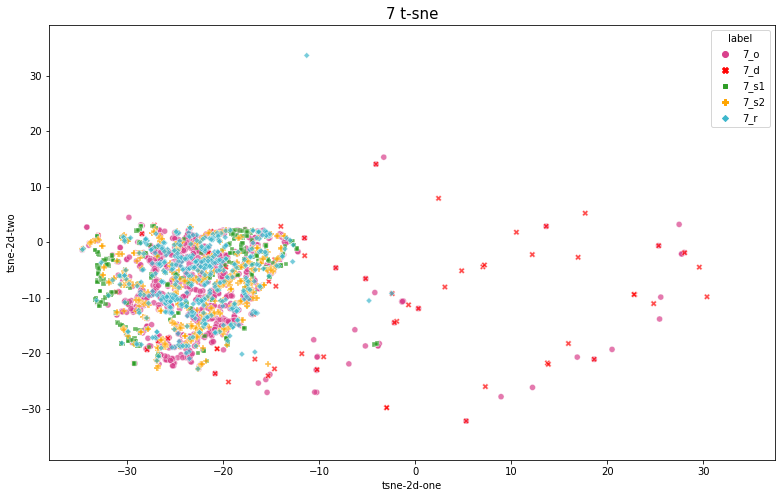

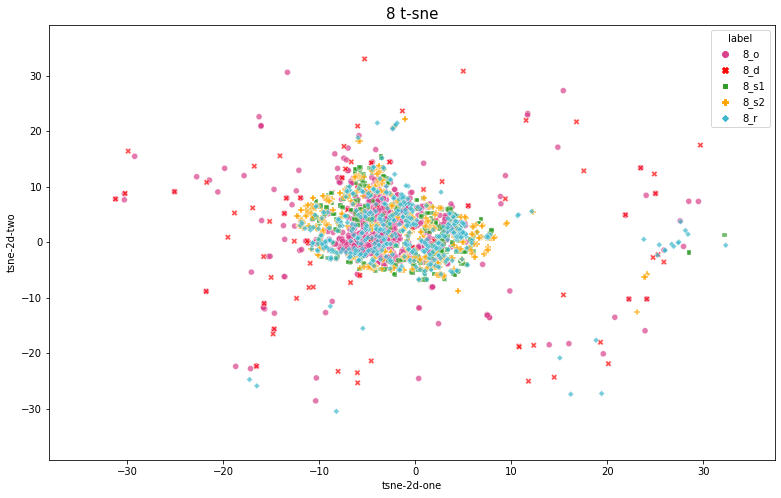

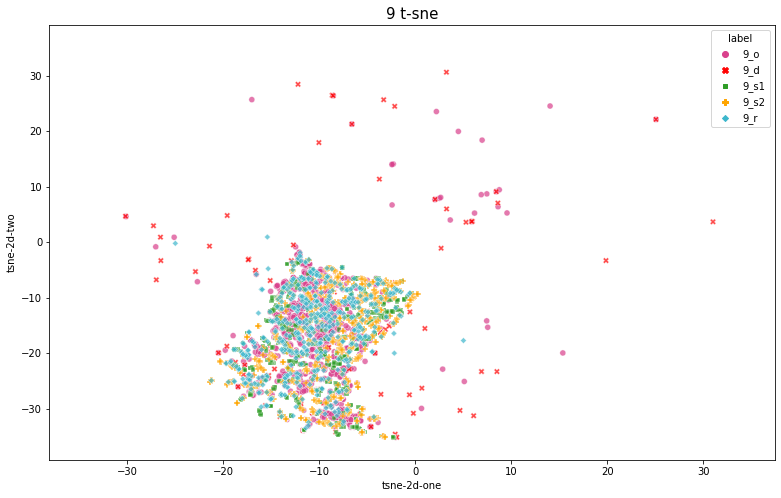

In [ ]:
for category in cat_list:
    draw_tsne(category)

In [ ]:
# random generate ratio, borderline smote1 ratio, borderline smote2 ratio

triplets = [(x/10.0, y/10.0, (10-x-y)/10.0) for x in range(0,11,2) for y in range(0,11-x,2)]
# triplets = triplets[::-1]
augnums = [[AUG_TOTAL*x for x in [a,b,c]] for a,b,c in triplets]

In [ ]:
len(danger_df)

676